In [1]:
import os
import time

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras import (
    Sequential,
    layers,
    optimizers,
    regularizers,
    callbacks,
    losses,
    activations,
)
import tensorflow_hub as hub 

In [2]:
device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
    raise SystemError('No GPU found!')
else:
    print(f'GPU found => {device_name}')

GPU found => /device:GPU:0
Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



# Constants

In [3]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
CLASS_NAMES = "daisy dandelion roses sunflowers tulips".split()

BATCH_SIZE = 256 if device_name == "/device:GPU:0" else 32

TRAIN_URL = "gs://practical-ml-vision-book/flowers_tfr/train-*"
VALID_URL = "gs://practical-ml-vision-book/flowers_tfr/valid-*"

MODEL_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"


# Helper Functions

In [4]:
def get_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H%M%S")
    return os.path.join("..", "..", "reports", "logs")


# Preprocessor

In [5]:
class _Preprocessor:
    def __init__(self):
        self.preproc_layers = Sequential(
            [
                layers.Lambda(
                    lambda img: tf.image.resize_with_pad(
                        img, 2 * IMG_HEIGHT, 2 * IMG_WIDTH
                    ),
                    input_shape=(None, None, 3),
                ),
                layers.CenterCrop(height=IMG_HEIGHT, width=IMG_WIDTH),
            ]
        )

    def read_from_tfr(self, proto):
        feature_description = {
            "image": tf.io.VarLenFeature(tf.float32),
            "shape": tf.io.VarLenFeature(tf.int64),
            "label": tf.io.FixedLenFeature([], tf.string, default_value=""),
            "label_int": tf.io.FixedLenFeature([], tf.int64, default_value=0),
        }

        record = tf.io.parse_single_example(proto, feature_description)
        shape = tf.sparse.to_dense(record["shape"])
        image = tf.reshape(tf.sparse.to_dense(record["image"]), shape)
        label_int = record["label_int"]
        return image, label_int

    def read_from_jpegfile(self, filename):
        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=IMG_CHANNELS)
        image = tf.image.convert_image_dtype(image, tf.float32)
        return image

    def preprocess(self, image):
        x = tf.expand_dims(image, 0)
        x = self.preproc_layers(x)
        x = tf.squeeze(x, 0)
        return x


In [6]:
def create_preproc_dataset(pattern):
    preprocessor = _Preprocessor()
    train_dataset = (
        tf.data.TFRecordDataset(
            [file for file in tf.io.gfile.glob(pattern)], compression_type="GZIP"
        )
        .map(preprocessor.read_from_tfr)
        .map(lambda image, label: (preprocessor.preprocess(image), label))
    )
    return train_dataset


def create_preproc_image(filename):
    preprocessor = _Preprocessor()
    image = preprocessor.read_from_jpegfile(filename)
    image = preprocessor.preprocess(image)
    return image


Let's read images from TFRecords:

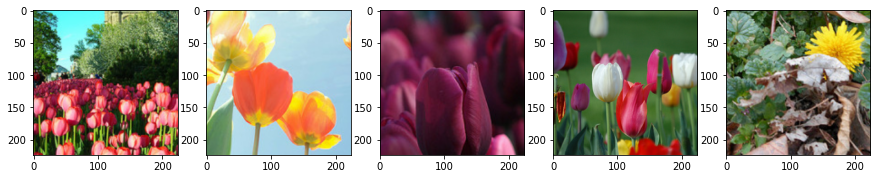

In [7]:
train_dataset = create_preproc_dataset(TRAIN_URL)
_, ax = plt.subplots(1, 5, figsize=(15, 15))
for idx, (image, label) in enumerate(train_dataset.take(5)):
    ax[idx].imshow((image.numpy()))

Now, let's process images:

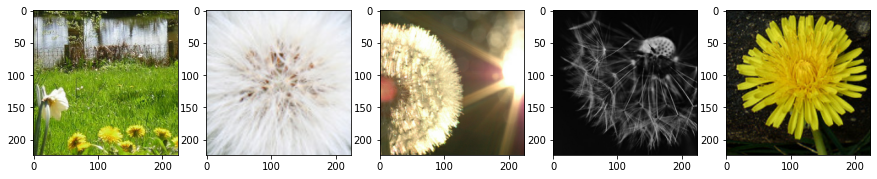

In [8]:
filenames = [
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/9818247_e2eac18894.jpg',
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/9853885425_4a82356f1d_m.jpg',
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/98992760_53ed1d26a9.jpg',
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/9939430464_5f5861ebab.jpg',
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/9965757055_ff01b5ee6f_n.jpg'
]

input_images = [create_preproc_image(image) for image in filenames]

_, ax = plt.subplots(1, 5, figsize=(15, 15))
for idx, image in enumerate(input_images):
    ax[idx].imshow((image.numpy()))

# Transfer Learning with MobileNet

In [9]:
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

def train_and_evaluate(lrate=0.001, l1=0.0, l2=0.0, num_hidden=16):
    regularizer = regularizers.l1_l2(l1, l2)
    
    train_dataset = create_preproc_dataset(TRAIN_URL).batch(BATCH_SIZE)
    valid_dataset = create_preproc_dataset(VALID_URL).batch(BATCH_SIZE)
    
    list_layers = [
        hub.KerasLayer(
            MODEL_URL,
            input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
            trainable=False,
            name='mobilenet_embedding'
        ),
        layers.Dense(
            num_hidden,
            kernel_regularizer=regularizer,
            kernel_initializer='he_normal',
            activation='elu',
            name='dense_hidden'
        ),
        layers.Dense(
            len(CLASS_NAMES),
            kernel_regularizer=regularizer,
            activation='softmax',
            name='flower_prob'
        )
    ]
    
    model = Sequential(list_layers, name='flower_classifier')
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lrate),
        loss=losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    
    logdir = get_logdir()
    tensorboard_cb = callbacks.TensorBoard(log_dir=logdir)
    
    print(model.summary())
    
    history = model.fit(
        train_dataset,
        validation_data=valid_dataset,
        epochs=10,
        callbacks=[tensorboard_cb],
        verbose=2
    )
    
    return model
    

In [10]:
!rm -rf ../../reports/logs

In [11]:
model = train_and_evaluate()

Model: "flower_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_embedding (KerasL  (None, 1280)             2257984   
 ayer)                                                           
                                                                 
 dense_hidden (Dense)        (None, 16)                20496     
                                                                 
 flower_prob (Dense)         (None, 5)                 85        
                                                                 
Total params: 2,278,565
Trainable params: 20,581
Non-trainable params: 2,257,984
_________________________________________________________________
None
Epoch 1/10
12/12 - 170s - loss: 1.3640 - accuracy: 0.4738 - val_loss: 0.9328 - val_accuracy: 0.6891 - 170s/epoch - 14s/step
Epoch 2/10
12/12 - 174s - loss: 0.6819 - accuracy: 0.7825 - val_loss: 0.6574 - val_accuracy: 0.7850 - 1

In [12]:
%load_ext tensorboard
%tensorboard --logdir=../../reports/logs

Reusing TensorBoard on port 6006 (pid 19071), started 1 day, 3:20:11 ago. (Use '!kill 19071' to kill it.)

In [13]:
def plot_predictions(model, pattern):
    dataset = create_preproc_dataset(pattern)
    _, ax = plt.subplots(3, 5, figsize=(25, 15))
    for idx, (image, label) in enumerate(dataset.take(15)):
        ax[idx//5, idx%5].imshow(image.numpy())
        batch_image = tf.reshape(image, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
        batch_pred = model.prediction(batch_image)
        pred = batch_pred[0]
        label = CLASS_NAMES[label.numpy()]
        pred_label_index = tf.math.argmax(pred).numpy()
        pred_label = CLASS_NAMES[pred_label_index]
        prob = pred[pred_label_index]
        title_label = '\u2714' if (label == pred_label) else f'\u2717 {label}'
        ax[idx // 5, idx % 5].set_title(f'{pred_label} ({prob:.2f}) {title_label}')
        ax[idx // 5, idx % 5].axis('off')

AttributeError: 'Sequential' object has no attribute 'prediction'

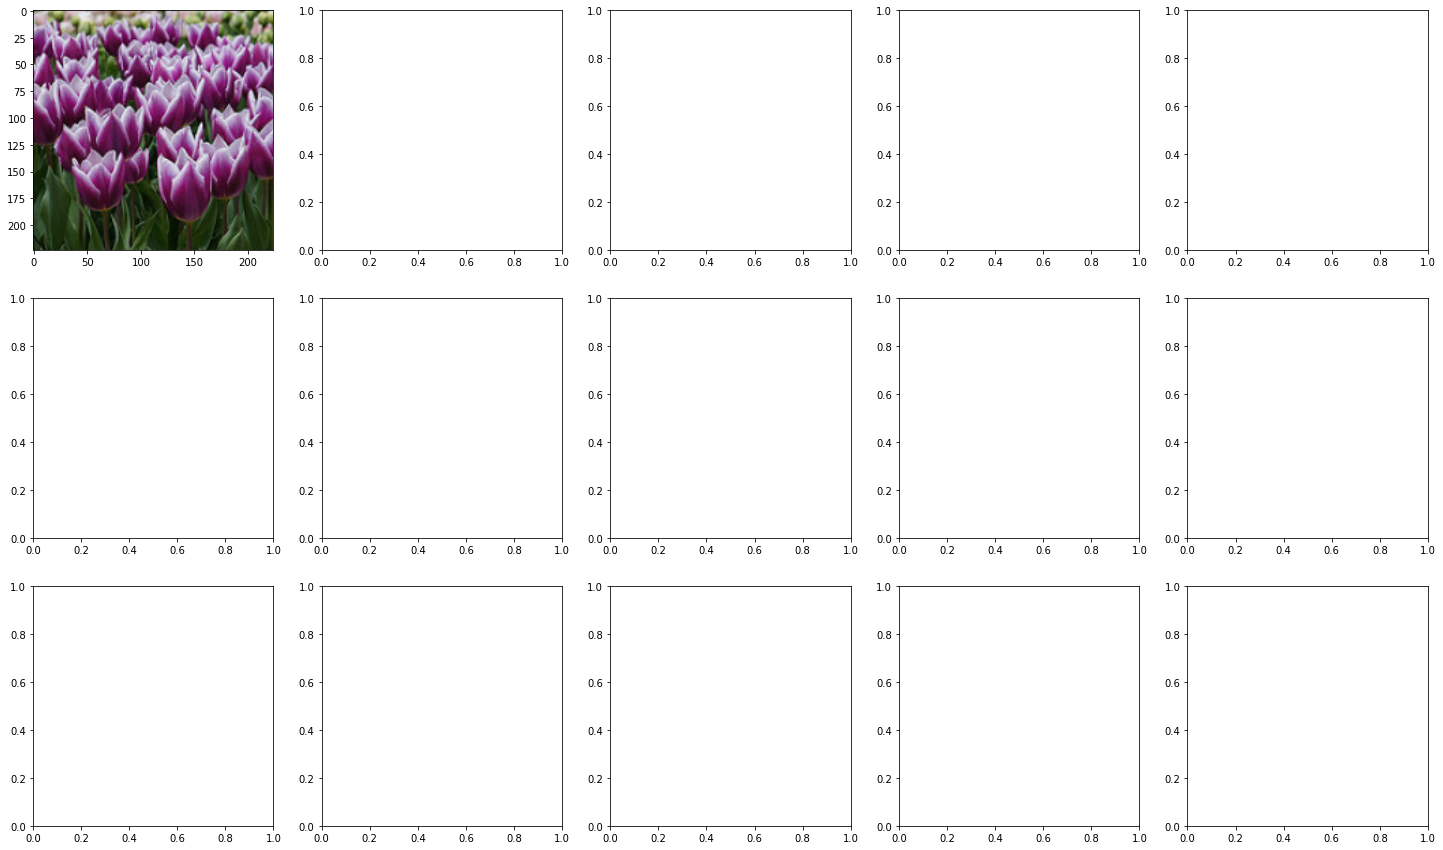

In [14]:
plot_predictions(model, VALID_URL)

In [ ]:
filenames = [
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/9818247_e2eac18894.jpg',
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/9853885425_4a82356f1d_m.jpg',
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/98992760_53ed1d26a9.jpg',
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/9939430464_5f5861ebab.jpg',
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/9965757055_ff01b5ee6f_n.jpg'
]
label = 'dandelion'

input_images = [create_preproc_image(file) for file in filenames]

_, ax = plt.subplots(1, 5, figsize=(25, 15))
for idx, image in enumerate(input_images):
    ax[idx].imshow(image.numpy())
    batch_image = tf.reshape(image, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    title_label = '\u2714' if (label == pred_label) else f'\u2717 {label}'
    ax[idx, idx].set_title(f'{pred_label} ({prob:.2f}) {title_label}')
    ax[idx, idx].axis('off')